# Week 8 Assignment

## Summary:

For this week's assignment, I chose the [medical transcriptions dataset from Kaggle](https://www.kaggle.com/tboyle10/medicaltranscriptions). In doing analysis on this data, my focus was to find trends and patterns among the write-ups for each transcription through word frequencies and estimating topic groups. Then I created a predictive model to determine the medical specialty categories for the transcription in the test data set.

In [1]:
import numpy as np
import pandas as pd
import string
import spacy

import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import silhouette_score
from sklearn.metrics import classification_report
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.naive_bayes import MultinomialNB

from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.probability import ConditionalFreqDist
from nltk.corpus import stopwords
from nltk.util import ngrams

en_stopwords = stopwords.words('english')  
stopwords = set(en_stopwords)  #stopwords has split contractions in it
nlp = spacy.load("en")

%matplotlib inline

In [2]:
#set location of data file
filename = "mtsamples.csv"

In [3]:
#load in dataset of medical transcriptions as a dataframe
df = pd.read_csv(filename)

In [4]:
#look at first five rows of dataframe
df.head()

,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


In [5]:
#list of column names
df.columns

Index(['Unnamed: 0', 'description', 'medical_specialty', 'sample_name',
       'transcription', 'keywords'],
      dtype='object')

In [6]:
#remove "Unnamed: 0" column from dataframe
df.drop('Unnamed: 0', axis=1, inplace=True)

### Explore Data

After reading in the dataset, I removed the `Unnamed: 0` column which was probably a carryover of an index position label when the creator scraped this dataset. I explored the non-null count distribution by column, the data types for each column, and the distribution of rows (transcriptions) by each category within the `medical-specialty` column. Lastly, I checked the structure of the text from a transcription in order to get a sense of a typical write-up.

In [7]:
#verify dataframe w/o "Unnamed: 0" column
df.head()

,description,medical_specialty,sample_name,transcription,keywords
0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


In [8]:
#get total of non-null values per column
df.count()

description          4999
medical_specialty    4999
sample_name          4999
transcription        4966
keywords             3931
dtype: int64

In [9]:
#show data type of each column
df.dtypes

description          object
medical_specialty    object
sample_name          object
transcription        object
keywords             object
dtype: object

In [10]:
#get number of categories in the "medical_specialty" column
#40 different medical specialty types assigned to the transciptions
len(df['medical_specialty'].unique())

40

In [11]:
#frequency of each medical specialty category
df['medical_specialty'].value_counts()

 Surgery                          1103
 Consult - History and Phy.        516
 Cardiovascular / Pulmonary        372
 Orthopedic                        355
 Radiology                         273
 General Medicine                  259
 Gastroenterology                  230
 Neurology                         223
 SOAP / Chart / Progress Notes     166
 Obstetrics / Gynecology           160
 Urology                           158
 Discharge Summary                 108
 ENT - Otolaryngology               98
 Neurosurgery                       94
 Hematology - Oncology              90
 Ophthalmology                      83
 Nephrology                         81
 Emergency Room Reports             75
 Pediatrics - Neonatal              70
 Pain Management                    62
 Psychiatry / Psychology            53
 Office Notes                       51
 Podiatry                           47
 Dermatology                        29
 Cosmetic / Plastic Surgery         27
 Dentistry               

In [12]:
#explore transcription text of first row in dataframe
df.iloc[0]['transcription']

'SUBJECTIVE:,  This 23-year-old white female presents with complaint of allergies.  She used to have allergies when she lived in Seattle but she thinks they are worse here.  In the past, she has tried Claritin, and Zyrtec.  Both worked for short time but then seemed to lose effectiveness.  She has used Allegra also.  She used that last summer and she began using it again two weeks ago.  It does not appear to be working very well.  She has used over-the-counter sprays but no prescription nasal sprays.  She does have asthma but doest not require daily medication for this and does not think it is flaring up.,MEDICATIONS: , Her only medication currently is Ortho Tri-Cyclen and the Allegra.,ALLERGIES: , She has no known medicine allergies.,OBJECTIVE:,Vitals:  Weight was 130 pounds and blood pressure 124/78.,HEENT:  Her throat was mildly erythematous without exudate.  Nasal mucosa was erythematous and swollen.  Only clear drainage was seen.  TMs were clear.,Neck:  Supple without adenopathy.,

In [13]:
#explore first row of dataframe
df.iloc[0]

description           A 23-year-old white female presents with comp...
medical_specialty                                 Allergy / Immunology
sample_name                                         Allergic Rhinitis 
transcription        SUBJECTIVE:,  This 23-year-old white female pr...
keywords             allergy / immunology, allergic rhinitis, aller...
Name: 0, dtype: object

### Clean Data

The `cleanCorpus` function reduces the text of a transciption to lemmatized terms that are not filler words or are numbers/punctuation. Before running the function, I made a dataframe that contained only the medical specialty categories and the transcription text, in order to decrease the text processing needed to use this data in a model. In the new dataframe, the `transcription` column was replaced with the `cleanCorpus` output.

In [14]:
"""
This function will take in each row of a pandas dataframe column (corpus) that contains each transcription as a string and make the text lowercase, 
remove punctuation/digits/special characters, convert it into a spaCy object (tokenizing), remove stopwords, and rejoin as a string.
The final string product is then returned to the dataframe.
"""

#function to lowercase, remove punctuation/digits, tokenize (split into words), and remove stopwords
def cleanCorpus(corpus):

    #remove punctuation, digits, and non-standard single quotes/apostrophes
    rmv = str.maketrans({key: None for key in string.punctuation + string.digits + "‘’"})

    #make string lowercase                    
    lower_str = corpus.translate(rmv).lower() 

    #make string into a spaCy object
    nlpdoc = nlp(lower_str)

    #holds tokens that are not stopwords
    clean_wordls = []

    #each token in the spaCy object
    for token in nlpdoc:
        
        #check to see if lemma of a word is a pronoun
        #if true, needs to be in regular text form (.lemma_ doesn't hold word)
        if token.lemma_ == '-PRON-':
            tknwd = token.text
        else:
            #lemmatize the word
            tknwd = token.lemma_

        
        #check to see if the token is a stopword
        if tknwd in stopwords: pass
            
        #if word is not a stopword, add to clean words list
        else:
            clean_wordls.append(tknwd)

            
    #join list of cleaned words together into one string
    clean_str = " ".join(clean_wordls)  
    
    #returned output is an item from corpus as a string
    return clean_str

In [15]:
#make a dataframe that only contains the "medical_specialty" and "trascription" columns
model_df = df[['medical_specialty', 'transcription']]

In [16]:
#keep the rows where the "transcription" column value is not missing (empty)
model_df = model_df.loc[df['transcription'].notnull()]

In [17]:
#clean the text in the "transcription" column
#assign cleaned text data back into the "transcription" column
model_df['transcription'] = model_df['transcription'].apply(cleanCorpus)

In [18]:
#verify the "transcription" column data is cleaned
model_df.head()

,medical_specialty,transcription
0,Allergy / Immunology,subjective yearold white female present comp...
1,Bariatrics,past medical history difficulty climb stair di...
2,Bariatrics,history present illness see abc today plea...
3,Cardiovascular / Pulmonary,mmode leave atrial enlargement left atrial...
4,Cardiovascular / Pulmonary,left ventricular cavity size wall thickness...


### Data Visualization

Although this is a medical-based dataset, I wanted to make word clouds for frequently occuring words and co-occuring words (bigrams) to find out if there were any particular terms that are consistent throughout the majority of the transcriptions. 

In [19]:
#make a list out of the "transcription" column
#each list item is a transcription
transcp_ls = list(model_df['transcription'])

In [20]:
#first 5 items in list
transcp_ls[0]

'subjective   yearold white female present complaint allergy   use allergy live seattle think bad   past try claritin zyrtec   work short time seem lose effectiveness   use allegra also   use last summer begin use two week ago   appear work well   use overthecounter spray prescription nasal spray   asthma require daily medication think flare upmedication   medication currently ortho tricyclen allegraallergie   know medicine allergiesobjectivevital   weight   pound blood pressure heent   throat mildly erythematous without exudate   nasal mucosa erythematous swollen   clear drainage see   tms clearneck   supple without adenopathylung   clearassessment   allergic rhinitisplan   try zyrtec instead allegra   another option use loratadine   think prescription coverage may cheap   sample nasonex two spray nostril give three week   prescription write well'

In [21]:
#put all items together into a whole string
#whole string is all the transcriptions put together
transcp_str = " ".join(transcp_ls)

In [22]:
#use word_tokenize function
#will convert string into a list
#each list item is a token(word)
#this list contains all the tokens(words) in the corpus
all_tknz = word_tokenize(transcp_str)

In [23]:
#make a frequency distribution of all the tokens
#convert FreqDist type into a normal python dictionary
#need to use for WordCloud function
wrdcnt_dict = dict(FreqDist(all_tknz))

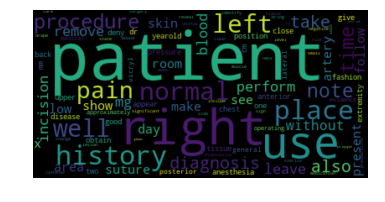

In [24]:
#make a word cloud of Top 100 words in the corpus
wc = WordCloud(max_words=100).generate_from_frequencies(wrdcnt_dict)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [25]:
#create bigrams from each transcription

#empty list to hold all bigrams in the corpus
all_bgs =[]

#each item in transcp_ls is a string
for transcription in transcp_ls:
    
    #create tokens for each transcription
    transcp_tknz = word_tokenize(transcription)
    
    #for each transcription (a list of tokens), make bigrams that exist in transcription
    for bigram in ngrams(transcp_tknz, 2):
        
        #append all bigrams from entire dataset into a list
        all_bgs.append(bigram)

In [26]:
#list of all bigrams in dataset
all_bgs[:5]

[('subjective', 'yearold'),
 ('yearold', 'white'),
 ('white', 'female'),
 ('female', 'present'),
 ('present', 'complaint')]

In [27]:
#most frequently occuring bigrams in all transcriptions
#this is a tuple
#first item in tuple is the bigram (as a tuple); second item is the frequency
bg_freq_tpl = FreqDist(all_bgs).most_common()

In [28]:
#empty list to hold bigram and its frequency
#will use to make word cloud
bgs_str_freq = {}

#for each bigram+frequency tuple
for bgs_tuple in bg_freq_tpl:
    
    #index 1 is the frequency
    #assign the frequency to variable "v"
    v = bgs_tuple[1]
    
    #index 0 is the bigram (as a tuple)
    #index 0 of the bigram is the first word; index 1 is the second word
    #put the 2 words together as a string with an underscore between them
    k = "_".join([bgs_tuple[0][0], bgs_tuple[0][1]])
    
    #add key and value to dictionary
    # variable "k" (key) is the bigram string; variable "v" (value) is the frequency
    bgs_str_freq[k] = v

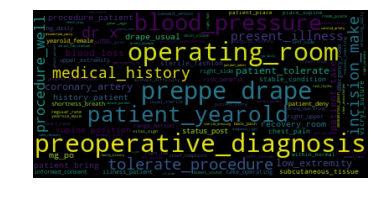

In [29]:
#word cloud of Top 100 bigrams in the corpus
wc = WordCloud(max_words=100).generate_from_frequencies(bgs_str_freq)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

### Topic Modeling

The medical specialty category has 40 distinct groups for the types of transcription write-ups, so I wanted to do topic modeling for just 10 groups to see if any of the terms associate with related medical specialty categories would be aggregated in the model. Then after assessing the ouput, I created a frequency distribution for terms that were assigned to a "dominant" topic (comparing a term's probability score for each topic determined by the Latent Dirichlet Allocation model). 

In [30]:
#assign the CountVecrtorizer function to a variable
cntvec = CountVectorizer()

In [31]:
#transform the "transcription" column into a matrix
#columns are the words(terms); rows are the transcription indicies
transcp_mtx = cntvec.fit_transform(model_df['transcription'])

In [32]:
#rows and columns of matrix
transcp_mtx.shape

(4966, 33357)

In [33]:
#set the LDA function to a variable
#LDA function will make 10 topics of distinguishing information
lda = LatentDirichletAllocation(n_components=10)

In [34]:
#build the LDA model with the transcription term matrix
transc_lda_mtx = lda.fit_transform(transcp_mtx)

In [35]:
#verify number of topics created by LDA model
len(lda.components_)

10

In [36]:
#get each topic group
#topics is a list; each item in list is the words in the topic
topics = lda.components_

#get the word(term) names; find string value of word by its index
term_model = cntvec.get_feature_names()

In [37]:
#get each topic and its index number
for idx, topic in enumerate(topics):
    
    #get top 10 word index numbers for each topic
    #topwords is an array
    topwords = topic.argsort()[-10:]
    
    #print out topic number
    print(f"Topic {idx}:\n")
    
    #get the string value of a term based on its index position in the CountVectorizer model
    topic_word_ls = [term_model[feature_num] for feature_num in topwords]
    
    #put list of words together as one whole string
    topic_word_str = " ".join(topic_word_ls)
    
    #show the words for the topic
    print(topic_word_str)
    
    #add newline to make space for next set of topic words
    print("\n")

Topic 0:

kidney within mass image exam ct evidence see right normal


Topic 1:

back time history extremity low patient normal left pain right


Topic 2:

area suture incision procedure skin place use left patient right


Topic 3:

room port use right diagnosis remove tube place procedure patient


Topic 4:

state year po pain time daily report history mg patient


Topic 5:

mg present without well day blood pain normal history patient


Topic 6:

position well right remove diagnosis cc use procedure place patient


Topic 7:

normal vein femoral patient catheter leave coronary left right artery


Topic 8:

bladder right skin close vicryl incision suture place use patient


Topic 9:

foot perform lateral well medial incision place right use patient




In [38]:
# column names
topicnames = [f"Topic {idx}" for idx, topic in enumerate(topics)]

# index names
transcrp_names = [f"Transcription {i}" for i in range(len(model_df))]

# Make the pandas dataframe
#round probabilities to two decimal spaces
df_document_topic = pd.DataFrame(np.round(transc_lda_mtx, 2), columns=topicnames, index=transcrp_names)

# Get dominant topic for each document
#"dominate topic" means whichever topic a term had the highest probability for
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

In [39]:
#make a dataframe from the frequency count of number of transcriptions that are in a particular dominant topic
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Transcriptions")

#rename columns
df_topic_distribution.columns = ['Topic Num', 'Num Documents']

#show dataframe
df_topic_distribution

,Topic Num,Num Documents
0,5,1398
1,1,515
2,9,508
3,6,505
4,8,437
5,3,381
6,2,374
7,4,313
8,7,290
9,0,245


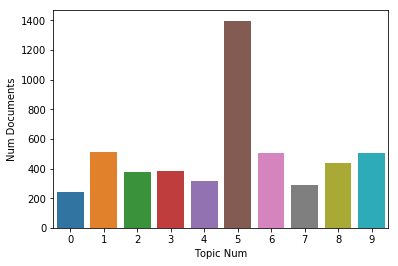

In [40]:
#frequency of transcriptions classified with most relevant topic (by highest probability)
sns.barplot(x='Topic Num', y='Num Documents', data=df_topic_distribution)

### Predictive Modeling

In order to predict the medical specialty categories, I had to transform the target variable (`medical_specialty`) into numerical values. Then after adding the numerical representatio of the target groups to the dataframe, I created training and test data for the Multinomial Naive Bayes classification model. I got the model performance results by acciracy score and also evaluating the proportion of Type I/Type II errors by category in the classsification report.

In [41]:
#put each medical speciality category name into a list
cat_names = list(model_df['medical_specialty'].unique())

In [42]:
#use medical specialty category name index positions to create a dictionary

target_val = {}

#for each category name and its index position number
for idx, category in enumerate(cat_names):
    
    #dict_key will be the category, dict_value is the index position
    target_val[category] = idx 

In [43]:
#completed dictionary with category, index pairs
target_val

{' Allergy / Immunology': 0,
 ' Autopsy': 39,
 ' Bariatrics': 1,
 ' Cardiovascular / Pulmonary': 2,
 ' Chiropractic': 38,
 ' Consult - History and Phy.': 37,
 ' Cosmetic / Plastic Surgery': 36,
 ' Dentistry': 4,
 ' Dermatology': 35,
 ' Diets and Nutritions': 34,
 ' Discharge Summary': 33,
 ' ENT - Otolaryngology': 30,
 ' Emergency Room Reports': 32,
 ' Endocrinology': 31,
 ' Gastroenterology': 29,
 ' General Medicine': 6,
 ' Hematology - Oncology': 28,
 ' Hospice - Palliative Care': 27,
 ' IME-QME-Work Comp etc.': 26,
 ' Lab Medicine - Pathology': 25,
 ' Letters': 24,
 ' Nephrology': 23,
 ' Neurology': 3,
 ' Neurosurgery': 22,
 ' Obstetrics / Gynecology': 21,
 ' Office Notes': 20,
 ' Ophthalmology': 19,
 ' Orthopedic': 18,
 ' Pain Management': 17,
 ' Pediatrics - Neonatal': 16,
 ' Physical Medicine - Rehab': 15,
 ' Podiatry': 14,
 ' Psychiatry / Psychology': 13,
 ' Radiology': 12,
 ' Rheumatology': 11,
 ' SOAP / Chart / Progress Notes': 9,
 ' Sleep Medicine': 10,
 ' Speech - Language':

In [44]:
#create column to hold the medical specialty category numbers
#numbers will be used to train the model (since model can't take string values)
#dictionary will look for medical specialty category then assign 'target' column the dict_val
model_df['target'] = model_df['medical_specialty'].map(target_val)

In [45]:
#verify first 5 rows of dataframe w/ new column
model_df.head()

,medical_specialty,transcription,target
0,Allergy / Immunology,subjective yearold white female present comp...,0
1,Bariatrics,past medical history difficulty climb stair di...,1
2,Bariatrics,history present illness see abc today plea...,1
3,Cardiovascular / Pulmonary,mmode leave atrial enlargement left atrial...,2
4,Cardiovascular / Pulmonary,left ventricular cavity size wall thickness...,2


In [46]:
#set the "transcription" column as a Series to the variable X
X = model_df['transcription']

#set the value that will be predicted (medical specialty category numbers) to a variable
y = model_df['target']

In [47]:
#verify first 5 rows in X
X.head()

0    subjective   yearold white female present comp...
1    past medical history difficulty climb stair di...
2    history present illness   see abc today   plea...
3    mmode     leave atrial enlargement left atrial...
4       left ventricular cavity size wall thickness...
Name: transcription, dtype: object

In [48]:
#make training and test sets to use for predictive model
#training set=60%, test set=40%
#X is "title", y is "target"
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=90, test_size=0.4)

In [49]:
#verify number of rows in training and test dataset
print(X_train.shape)
print(X_test.shape)

(2979,)
(1987,)


In [50]:
#set TF-IDF vectorizer fucntion to a variable
tfidf_vec = TfidfVectorizer()

In [51]:
#turn text data into a TF-IDF matrix
#each column is a "term"(word)
#each row is a transcription
X_train_mtx = tfidf_vec.fit_transform(X_train)

In [52]:
#2979 rows, 30152 columns
X_train_mtx.shape

(2979, 30150)

In [53]:
#set Multinomial Naive Bayes function to a variable
mnb = MultinomialNB()

In [54]:
#build model using training dataset
#teach model the pattern/trends in the data
mnb.fit(X_train_mtx, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [55]:
#accuracy score of how well model can predict training data it learned from
mnb.score(X_train_mtx, y_train)

0.32863376972138303

In [56]:
#turn the test data into a TF-IDF matrix
X_test_mtx = tfidf_vec.transform(X_test)

In [57]:
#feed the test data into the model
#put predictive output into variable "y_predict"
y_predict = mnb.predict(X_test_mtx)

In [58]:
#model accuracy score on the test data
mnb.score(X_test_mtx, y_test)

0.3256165072974333

In [59]:
#predictive scores from decision tree model by category
print(classification_report(y_test, y_predict, target_names=cat_names))

C:\Users\Nisha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Nisha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Nisha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                                precision    recall  f1-score   support

          Allergy / Immunology       0.00      0.00      0.00         3
                    Bariatrics       0.00      0.00      0.00         9
    Cardiovascular / Pulmonary       0.50      0.12      0.20       146
                     Neurology       0.25      0.01      0.02        88
                     Dentistry       0.00      0.00      0.00        12
                       Urology       0.00      0.00      0.00        64
              General Medicine       0.00      0.00      0.00       107
                       Surgery       0.36      1.00      0.53       442
             Speech - Language       0.00      0.00      0.00         2
 SOAP / Chart / Progress Notes       0.00      0.00      0.00        72
                Sleep Medicine       0.00      0.00      0.00         4
                  Rheumatology       0.00      0.00      0.00         3
                     Radiology       0.00      0.00      0.00  

## Conclusion:

In conducting the EDA for this dataset, I did not find any surprising results for the frequency of unigrams. The word "patient" was mentioned the most throughout the corpus but it is to be expected since transcription write-ups are usually about the medical conditions of a patient and any other follow-on notes that were made at other medical appointments. However, the bigram word cloud was far more interesting because terms such as "preooperative diagnosis", "operating room", "incision make", "preppe drape", and "procedure well" were prominent and led me to think that many of the medical specialty categories have write-ups containing information about a patient's surgery (pre- and post-surgery), and is not only limited to being mentioned within the "Surgery" classified transcriptions. Other bigram phrases like "patient years old" and "medical history" were typical recorded information.

From the topic modeling analysis, the results of each topic formed by Latent Dirichlet Allocation (LDA) mostly contained words related to surgeries but the distinguishing factors were the body part/region that the surgery was conducted on. Topics 7, 8, and 9 seem to refer to hip (femoral), bladder, and feet surgeries, respectively; topics 4-6 describe either post-surgery recovery information and/or information about medicine patients are prescribed to take, either from prexisting conditions or as part of post-surgery recovery. Topics 0 and 1 look like pre-surgery diagnostic information, or maybe even information written during an initial appointment that led to a diagnosis of a condition. In the dominant document distribution, topic 5 had the most number of transriptions that had the highest probability value from the LDA model. The words are mostly generic, such as "mg" (for miligrams of medicine dosage), "blood", "pain", "normal" and "history" which is standard information across all medical specialty categories when assessing a patient's issue/illness. 

The results of the Multinomial Naive Bayes classification model were consistent across the training and testing sets (both performing at a ~33% accuracy rate), despite being skewed towards predictions for categories that were highly represented in the original dataset. The model had the best precision score for the "Cardiovascular/Pulmonary" category, followed by "Surgery", "Neurology", and "Consult - History and Phy.", however it was surprising to see a high recall score for "Consult - History and Phy." (89%). This indiciates that out of all the data points the model predicted to be within this category, 89% of those results were actually correct (true positives) which means that there must be very distinctive words/features about the transcriptions in this category that do not appear in others or have much lower frequency or relevance. It may be difficult to improve the model's results for future testing because many of the medical specialty categories have overlap of descriptive terms, so one solution could be to remove common medical terms (filler words specifically within this industry) that had the most appearance in the word cloud and then see if the model can pick up on more unique word trends.

### References:

Boyle, T. (2018, October 15). Medical Transcriptions. Retrieved from https://www.kaggle.com/tboyle10/medicaltranscriptions/metadata

Bengfort, B., Bilbro, R., & Ojeda, T. (2018). *Chapter 6: Clustering for Text Similarity (pp.111-114)*. Sebastopol, CA: OReilly Media.

LDA - How to grid search best topic models? (with examples in python). (2018, May 07). Retrieved from https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/